Import Libraries

In [1]:
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')

Fetching historical data for Apple stock (AAPL) from Yahoo Finance

In [2]:
ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-12-31"
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


Selecting only the 'Close' prices

In [3]:
data = data[['Close']]

Load the dataset

In [4]:
data = data['Close'].values.reshape(-1, 1)

Normalize the dataset

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

Splitting the dataset into training and testing sets

In [6]:
train_size = int(len(data_normalized) * 0.8)
test_size = len(data_normalized) - train_size
train_data, test_data = data_normalized[0:train_size,:], data_normalized[train_size:len(data_normalized),:]

Function to create dataset with look back

In [7]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

Reshape dataset for LSTM

In [8]:
look_back = 50
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

Reshape input to be [samples, time steps, features]

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Build LSTM model

In [10]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0071
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 9.9254e-04
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 6.5129e-04
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 6.5228e-04
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 4.9404e-04
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 5.2868e-04
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 3.9775e-04
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 4.0547e-04
Epoch 9/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 3.0606e-04
Epoch 10/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 2.9239e-04
Epoch 11/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 3.1296e-04
Epoch 12/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 3.4993e-04
Epoch 13/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 2.8086e-04
Epoch 14/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 3.06

Predictions

In [11]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step


Invert predictions

In [12]:
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

Plotting the results

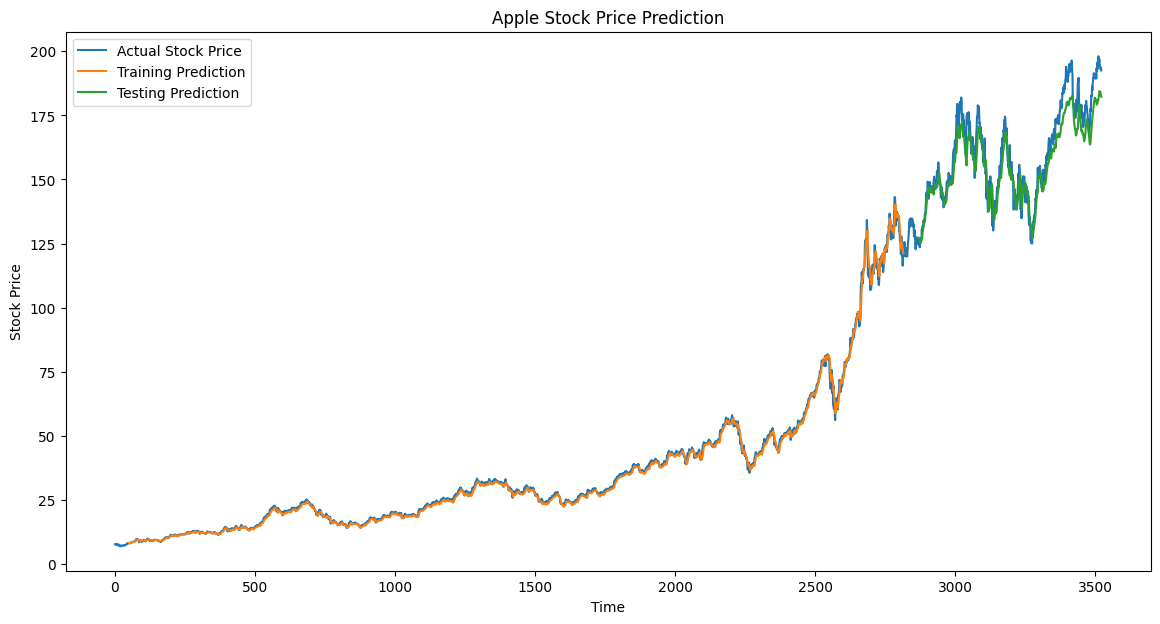

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(data, label='Actual Stock Price')
plt.plot(np.arange(look_back, len(train_predict)+look_back), train_predict, label='Training Prediction')
plt.plot(np.arange(len(data)-len(test_predict), len(data)), test_predict, label='Testing Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Apple Stock Price Prediction')
plt.legend()
plt.show()